In [21]:
using Pkg
Pkg.activate("..")  #one level up, where Project.toml lives
Pkg.instantiate()   #download/install anything missing
# Pkg.status();

  Activating project at `~/Documents/repos/JuliaExploreHRM`


In [22]:
include(joinpath(@__DIR__, "..", "hrm_common.jl"))

testo (generic function with 1 method)

In [44]:
using Plots, Test

In [37]:
#data generator
# y = w^T x + 0.1 * ||x||^2 + eps, where ( eps is N(0, 0.01) )

struct ToyGen
    w::Vector{Float32}
end

function ToyGen(d_in::Int; seed::Int=123)
    Random.seed!(seed)
    w = randn(Float32, d_in)
    return ToyGen(w)
end

#returns (x, y) with shapes (d_in, batch), (1, batch)
function sample!(gen::ToyGen, batch::Int)
    d = length(gen.w)
    x = randn(Float32, d, batch)
    # linear part
    y_lin = gen.w' * x      # (1, batch)
    # small quadratic interaction
    y_quad = 0.1f0 .* sum(abs2, x; dims=1)    # (1, batch)
    # noise
    eps = 0.01f0 .* randn(Float32, 1, batch)
    y = Float32.(y_lin .+ y_quad .+ eps)
    return x, y
end

sample! (generic function with 1 method)

In [33]:
CFG = (
    d_in   = 16,     # input features
    d_hid  = 64,     # hidden/state size (L and H)
    d_out  = 1,      # output size
    N      = 2,      # high-level cycles per segment
    T      = 3,      # low-level steps per H cycle
    M      = 1,      # segments per batch
    batch  = 64,     # batch size
    lr     = 1e-3,   # learning rate
    steps  = 300,    # training steps
    seed   = 42      # RNG seed
)

Random.seed!(42)

TaskLocalRNG()

In [34]:
#Model builders (Chains only)
function build_models(cfg)
    d_in, d_hid, d_out = cfg.d_in, cfg.d_hid, cfg.d_out

    fI = Lux.Chain(
        Lux.Dense(d_in => d_hid, NNlib.gelu)
    )

    # projections used inside fL/fH
    proj_task = Lux.Chain(Lux.Dense(d_hid => d_hid))
    proj_high = Lux.Chain(Lux.Dense(d_hid => d_hid))
    proj_low  = Lux.Chain(Lux.Dense(d_hid => d_hid))

    # MLP "encoder-like" cells (swap for attention later)
    fL_cell = Lux.Chain(
        Lux.LayerNorm(d_hid),
        Lux.Dense(d_hid => 4d_hid, NNlib.gelu),
        Lux.Dense(4d_hid => d_hid)
    )
    fH_cell = Lux.Chain(
        Lux.LayerNorm(d_hid),
        Lux.Dense(d_hid => 4d_hid, NNlib.gelu),
        Lux.Dense(4d_hid => d_hid)
    )

    fO = Lux.Chain(Lux.Dense(d_hid => d_out))

    return (; fI, proj_task, proj_high, proj_low, fL_cell, fH_cell, fO)
end

build_models (generic function with 1 method)

In [35]:

function setup_params_states(models)
    rng = Random.default_rng()
    psI,  stI  = Lux.setup(rng, models.fI)
    psPT, stPT = Lux.setup(rng, models.proj_task)
    psPH, stPH = Lux.setup(rng, models.proj_high)
    psPL, stPL = Lux.setup(rng, models.proj_low)
    psLc, stLc = Lux.setup(rng, models.fL_cell)
    psHc, stHc = Lux.setup(rng, models.fH_cell)
    psO,  stO  = Lux.setup(rng, models.fO)

    ps = (I=psI, PT=psPT, PH=psPH, PL=psPL, Lc=psLc, Hc=psHc, O=psO)
    st = (I=stI, PT=stPT, PH=stPH, PL=stPL, Lc=stLc, Hc=stHc, O=stO)
    return ps, st
end

setup_params_states (generic function with 1 method)

In [38]:
loss_fn(yhat, y) = mean(abs2, yhat .- y)

function init_states(batch::Int, d::Int)
    return (zeros(Float32, d, batch), zeros(Float32, d, batch))  # (low, high)
end

init_states (generic function with 1 method)

In [39]:
function run_segment!(models, ps, st, x, low_state, high_state; N::Int, T::Int)
    # task embedding from input
    e_task, stI = Lux.apply(models.fI, x, ps.I, st.I)

    stPT, stPH, stPL, stLc, stHc = st.PT, st.PH, st.PL, st.Lc, st.Hc

    for k in 1:N
        # low-level T steps
        for t in 1:T
            et,  stPT = Lux.apply(models.proj_task, e_task,      ps.PT, stPT)
            hh,  stPH = Lux.apply(models.proj_high, high_state,  ps.PH, stPH)
            xL = low_state .+ et .+ hh
            yL, stLc = Lux.apply(models.fL_cell, xL, ps.Lc, stLc)
            low_state = xL .+ yL
        end
        # one high-level step
        ll,  stPL = Lux.apply(models.proj_low, low_state, ps.PL, stPL)
        xH = high_state .+ ll
        yH, stHc = Lux.apply(models.fH_cell, xH, ps.Hc, stHc)
        high_state = xH .+ yH
    end

    yhat, stO = Lux.apply(models.fO, high_state, ps.O, st.O)
    st_new = (I=stI, PT=stPT, PH=stPH, PL=stPL, Lc=stLc, Hc=stHc, O=stO)
    return yhat, st_new, low_state, high_state
end

run_segment! (generic function with 3 methods)

In [40]:
function train_step!(models, ps, st, opt, gen, cfg)
    # batch
    x, y = sample!(gen, cfg.batch)

    # recurrent states
    low_state, high_state = init_states(cfg.batch, cfg.d_hid)

    total_loss = 0.0f0

    for m in 1:cfg.M
        # closure for pullback
        function seg_loss(ps_local)
            yhat, st_new, low_new, high_new =
                run_segment!(models, ps_local, st, x, low_state, high_state; N=cfg.N, T=cfg.T)
            L = loss_fn(yhat, y)
            return L, (st_new, low_new, high_new)
        end

        (L, (st_new, low_new, high_new)), back = Zygote.pullback(seg_loss, ps)
        grads = back((one(L), nothing))[1]
        opt, ps = Optimisers.update(opt, ps, grads)
        st = st_new
        total_loss += L

        # detach states between segments
        low_state  = Zygote.dropgrad(low_new)
        high_state = Zygote.dropgrad(high_new)
    end

    return total_loss, ps, st, opt
end

train_step! (generic function with 1 method)

In [42]:
models = build_models(CFG)
ps, st  = setup_params_states(models)
opt     = Optimisers.setup(Optimisers.Adam(CFG.lr), ps)
gen     = ToyGen(CFG.d_in; seed=31415)

loss_hist = Float32[]
for step in 1:CFG.steps
    L, ps, st, opt = train_step!(models, ps, st, opt, gen, CFG)
    push!(loss_hist, L)
    if step % 25 == 0
        @info "step=$(step) loss=$(round(L; digits=4))"
    end
end

┌ Info: step=25 loss=2.0577
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/01_minimal/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:11
┌ Info: step=50 loss=0.7008
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/01_minimal/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:11
┌ Info: step=75 loss=0.5466
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/01_minimal/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:11
┌ Info: step=100 loss=0.7609
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/01_minimal/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:11
┌ Info: step=125 loss=0.4621
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/01_minimal/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:11
┌ Info: step=150 loss=0.5557
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/01_minimal/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:11
┌ Info: step=175 loss=0.3

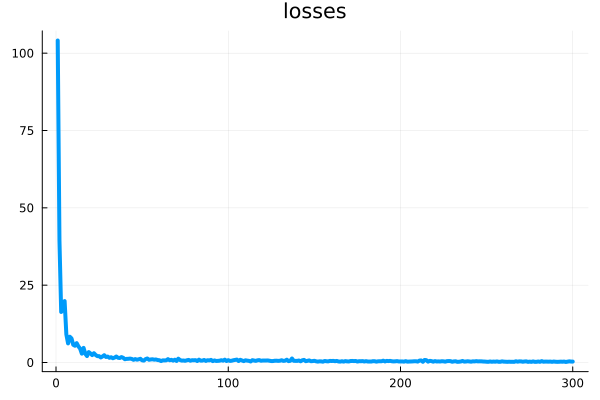

In [43]:
p = plot(loss_hist, title="losses", linewidth=4, legend=false)
savefig(p,"figures/losses.png")
display(p)

In [46]:
x_test, y_test = sample!(gen, CFG.batch)

low0, high0 = init_states(CFG.batch, CFG.d_hid)
yhat, st_tmp, _, _ = run_segment!(models, ps, st, x_test, low0, high0; N=CFG.N, T=CFG.T)

@test size(yhat) == (CFG.d_out, CFG.batch)
@test loss_fn(yhat, y_test) < 0.6

Test Passed

In [47]:
function predict(models, ps, st, x; N=CFG.N, T=CFG.T)
    batch = size(x, 2)
    low, high = init_states(batch, CFG.d_hid)
    yhat, _, _, _ = run_segment!(models, ps, st, x, low, high; N=N, T=T)
    return yhat
end

predict (generic function with 1 method)

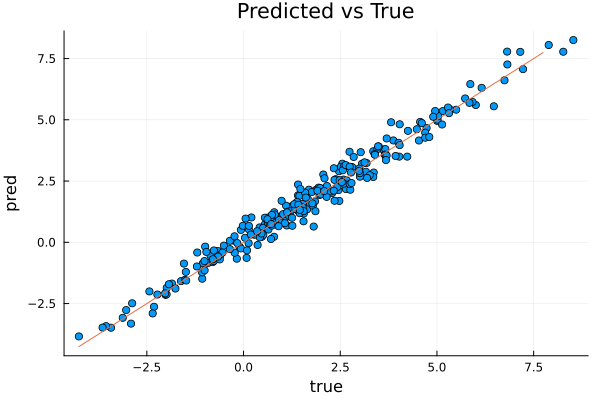

┌ Info: R^2 on held-out toy batch
│   r2 = 0.9742381
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/01_minimal/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X36sZmlsZQ==.jl:15


In [49]:
# small test set
batch_vis = 256
x_vis, y_vis = sample!(gen, batch_vis)
yhat_vis = predict(models, ps, st, x_vis)

# convert to vectors for plotting / stats
y_true = vec(Array(y_vis))   # (batch_vis,)
y_pred = vec(Array(yhat_vis))

# R^2 as a quick goodness-of-fit
mean_y = mean(y_true)
ss_tot = sum((y_true .- mean_y).^2)
ss_res = sum((y_true .- y_pred).^2)
r2 = 1 - ss_res / ss_tot
@info "R^2 on held-out toy batch" r2


p = scatter(y_true, y_pred; xlabel="true", ylabel="pred", title="Predicted vs True", legend=false)
plot!(minimum(y_true):maximum(y_true), minimum(y_true):maximum(y_true)) # y=x line
savefig(p,"figures/predicted_true.png")
display(p)


In [27]:


# ---------------------------
# Hyperparameters
# ---------------------------
Random.seed!(42)

d_in   = 16      # input feature dimension
d_hid  = 64      # hidden/state dimension for both L and H (you can split later)
d_out  = 1       # scalar regression target (toy task)
N      = 2       # high-level cycles per segment
T      = 3       # low-level steps per high-level cycle
M      = 1       # segments per batch (set >1 to use deep supervision)
batch  = 32      # batch size
lr     = 1e-3    # learning rate
steps  = 200     # training steps

# ---------------------------
# Models as Lux.Chain (no custom wrappers)
# ---------------------------

# fI: input encoder -> e_task in R^{d_hid}
fI = Lux.Chain(
    Lux.Dense(d_in => d_hid, NNlib.gelu)
)

# Projections used inside fL and fH
proj_task = Lux.Chain(Lux.Dense(d_hid => d_hid))  # project e_task to d_hid
proj_high = Lux.Chain(Lux.Dense(d_hid => d_hid))  # project high_state to d_hid
proj_low  = Lux.Chain(Lux.Dense(d_hid => d_hid))  # project low_state to d_hid

# "Encoder-style" MLP cells with LayerNorm and residual done externally
fL_cell = Lux.Chain(
    Lux.LayerNorm(d_hid),
    Lux.Dense(d_hid => 4d_hid, NNlib.gelu),
    Lux.Dense(4d_hid => d_hid)
)

fH_cell = Lux.Chain(
    Lux.LayerNorm(d_hid),
    Lux.Dense(d_hid => 4d_hid, NNlib.gelu),
    Lux.Dense(4d_hid => d_hid)
)

# Output head on high-level state
fO = Lux.Chain(
    Lux.Dense(d_hid => d_out)
)

# ---------------------------
# Parameters and States
# ---------------------------
rng = Random.default_rng()

psI, stI   = Lux.setup(rng, fI)
psPT, stPT = Lux.setup(rng, proj_task)
psPH, stPH = Lux.setup(rng, proj_high)
psLc, stLc = Lux.setup(rng, fL_cell)
psPL, stPL = Lux.setup(rng, proj_low)
psHc, stHc = Lux.setup(rng, fH_cell)
psO,  stO  = Lux.setup(rng, fO)

# Bundle parameter and state trees so Optimisers can update everything at once
ps = (I=psI, PT=psPT, PH=psPH, Lc=psLc, PL=psPL, Hc=psHc, O=psO)
st = (I=stI, PT=stPT, PH=stPH, Lc=stLc, PL=stPL, Hc=stHc, O=stO)

opt = Optimisers.setup(Optimisers.Adam(lr), ps)

# ---------------------------
# Utilities
# ---------------------------
loss_fn(yhat, y) = mean(abs2, yhat .- y)

# Lux.apply shortcut
apply!(m, p, s, x) = Lux.apply(m, x, p, s)

# Initialize recurrent states as features x batch
function init_states(b::Int, d::Int)
    return (zeros(Float32, d, b), zeros(Float32, d, b))  # (low_state, high_state)
end

# ---------------------------
# One forward segment (N x T steps)
# ---------------------------
function run_segment!(ps, st, x, low_state, high_state; N::Int=2, T::Int=3)
    # Static task embedding from input
    e_task, stI = apply!(fI, ps.I, st.I, x)

    # Local copies of module states for this segment
    stPT, stPH, stLc, stPL, stHc = st.PT, st.PH, st.Lc, st.PL, st.Hc

    # Two-clock recurrence
    for k in 1:N
        # Low-level T steps
        for t in 1:T
            et,  stPT = apply!(proj_task, ps.PT, stPT, e_task)      # (d_hid, batch)
            hh,  stPH = apply!(proj_high, ps.PH, stPH, high_state)  # (d_hid, batch)
            xL        = low_state .+ et .+ hh                       # fuse inputs
            yL, stLc  = apply!(fL_cell, ps.Lc, stLc, xL)            # cell transform
            low_state = xL .+ yL                                    # residual
        end
        # One high-level step
        ll,  stPL   = apply!(proj_low, ps.PL, stPL, low_state)
        xH          = high_state .+ ll
        yH, stHc    = apply!(fH_cell, ps.Hc, stHc, xH)
        high_state  = xH .+ yH
    end

    # Output on high-level state
    yhat, stO = apply!(fO, ps.O, st.O, high_state)

    # Updated module state tree
    st_new = (I=stI, PT=stPT, PH=stPH, Lc=stLc, PL=stPL, Hc=stHc, O=stO)

    return yhat, st_new, low_state, high_state
end

# ---------------------------
# Training loop (one-step gradient; no BPTT)
# ---------------------------
losses = []

for step in 1:steps
    # Toy batch: predict sum of inputs along features
    # Shapes must be features x batch everywhere
    x = randn(Float32, d_in, batch)             # (d_in, batch)
    y = Array{Float32}(sum(x; dims=1))          # (1, batch)

    # Recurrent states for this batch
    low_state, high_state = init_states(batch, d_hid)

    total_loss = 0.0f0

    # Optionally run multiple segments M with detach between them
    for m in 1:M
        function seg_loss(ps_local)
            yhat, st_new, low_new, high_new = run_segment!(ps_local, st, x, low_state, high_state; N=N, T=T)
            loss = loss_fn(yhat, y)
            return loss, (st_new, low_new, high_new)
        end

        (loss, (st_new, low_new, high_new)), back = Zygote.pullback(seg_loss, ps)
        grads = back((one(loss), nothing))[1]

        opt, ps = Optimisers.update(opt, ps, grads)
        st = st_new
        total_loss += loss
        push!(losses, loss)

        # Detach recurrent states between segments to keep O(1) memory
        low_state  = Zygote.dropgrad(low_new)
        high_state = Zygote.dropgrad(high_new)
    end

    if step % 20 == 0
        @show step total_loss
    end
end


step = 20
total_loss = 8.288907f0
step = 40
total_loss = 2.309877f0
step = 60
total_loss = 1.8548931f0
step = 80
total_loss = 1.6356689f0
step = 100
total_loss = 1.0645303f0
step = 120
total_loss = 1.7793024f0
step = 140
total_loss = 1.7453768f0
step = 160
total_loss = 1.9891516f0
step = 180
total_loss = 0.9830436f0
step = 200
total_loss = 1.2019691f0


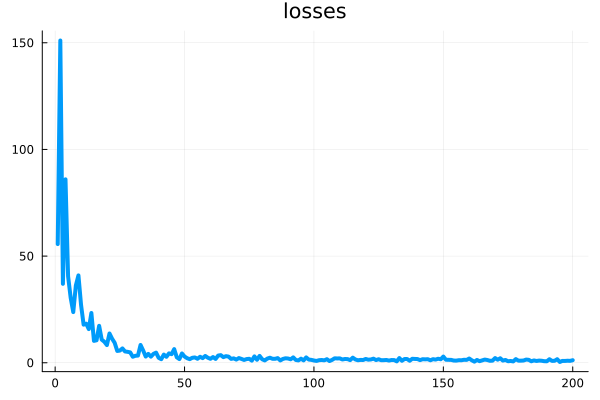

In [32]:
p = plot(losses, title="losses", linewidth=4, legend=false)
savefig(p,"figures/losses.png")
display(p)